# 데모

## 라이브러리 import 및 설정

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [28]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드 

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [29]:
data_dir = Path('./input')
feature_dir = Path('./input')
sub_dir = Path('./input')
val_dir = Path('./input')
tst_dir = Path('./input')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 7
n_class = 3
seed = 42

In [30]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [31]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.3723,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-1.5721
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.5266,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.1666
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,0.7413,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.3573
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,0.9591,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-0.4272
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.2917,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-1.2732


In [32]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## Stratified K-Fold Cross Validation

In [43]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

## LightGBM 모델 학습

In [44]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=3000,
                             num_leaves=128,
                             learning_rate=0.02,
                             min_child_samples=10,
                             subsample=.9,
                             subsample_freq=1,
                             colsample_bytree=.9,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.958893
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.932959
[3]	valid_0's multi_logloss: 0.906725
[4]	valid_0's multi_logloss: 0.881805
[5]	valid_0's multi_logloss: 0.858161
[6]	valid_0's multi_logloss: 0.835506
[7]	valid_0's multi_logloss: 0.815521
[8]	valid_0's multi_logloss: 0.798124
[9]	valid_0's multi_logloss: 0.779734
[10]	valid_0's multi_logloss: 0.7605
[11]	valid_0's multi_logloss: 0.742048
[12]	valid_0's multi_logloss: 0.724454
[13]	valid_0's multi_logloss: 0.707803
[14]	valid_0's multi_logloss: 0.691539
[15]	valid_0's multi_logloss: 0.675884
[16]	valid_0's multi_logloss: 0.660735
[17]	valid_0's multi_logloss: 0.646232
[18]	valid_0's multi_logloss: 0.632275
[19]	valid_0's multi_logloss: 0.618843
[20]	valid_0's multi_logloss: 0.606876
[21]	valid_0's multi_logloss: 0.594298
[22]	valid_0's multi_logloss: 0.582311
[23]	valid_0's multi_logloss: 0.570539
[24]	valid_0's multi_logloss

[209]	valid_0's multi_logloss: 0.171225
[210]	valid_0's multi_logloss: 0.171068
[211]	valid_0's multi_logloss: 0.170929
[212]	valid_0's multi_logloss: 0.170754
[213]	valid_0's multi_logloss: 0.170623
[214]	valid_0's multi_logloss: 0.170467
[215]	valid_0's multi_logloss: 0.170331
[216]	valid_0's multi_logloss: 0.170192
[217]	valid_0's multi_logloss: 0.17005
[218]	valid_0's multi_logloss: 0.169902
[219]	valid_0's multi_logloss: 0.169774
[220]	valid_0's multi_logloss: 0.169641
[221]	valid_0's multi_logloss: 0.169513
[222]	valid_0's multi_logloss: 0.169392
[223]	valid_0's multi_logloss: 0.169262
[224]	valid_0's multi_logloss: 0.169146
[225]	valid_0's multi_logloss: 0.169007
[226]	valid_0's multi_logloss: 0.168896
[227]	valid_0's multi_logloss: 0.168796
[228]	valid_0's multi_logloss: 0.168682
[229]	valid_0's multi_logloss: 0.168585
[230]	valid_0's multi_logloss: 0.168476
[231]	valid_0's multi_logloss: 0.168356
[232]	valid_0's multi_logloss: 0.168248
[233]	valid_0's multi_logloss: 0.168157
[

[417]	valid_0's multi_logloss: 0.161218
[418]	valid_0's multi_logloss: 0.1612
[419]	valid_0's multi_logloss: 0.161196
[420]	valid_0's multi_logloss: 0.161186
[421]	valid_0's multi_logloss: 0.161177
[422]	valid_0's multi_logloss: 0.161172
[423]	valid_0's multi_logloss: 0.16115
[424]	valid_0's multi_logloss: 0.16114
[425]	valid_0's multi_logloss: 0.161133
[426]	valid_0's multi_logloss: 0.161128
[427]	valid_0's multi_logloss: 0.16112
[428]	valid_0's multi_logloss: 0.161111
[429]	valid_0's multi_logloss: 0.161107
[430]	valid_0's multi_logloss: 0.161096
[431]	valid_0's multi_logloss: 0.16108
[432]	valid_0's multi_logloss: 0.161065
[433]	valid_0's multi_logloss: 0.161063
[434]	valid_0's multi_logloss: 0.161041
[435]	valid_0's multi_logloss: 0.161031
[436]	valid_0's multi_logloss: 0.161022
[437]	valid_0's multi_logloss: 0.161013
[438]	valid_0's multi_logloss: 0.161002
[439]	valid_0's multi_logloss: 0.160989
[440]	valid_0's multi_logloss: 0.160983
[441]	valid_0's multi_logloss: 0.160974
[442]	

[22]	valid_0's multi_logloss: 0.581591
[23]	valid_0's multi_logloss: 0.569868
[24]	valid_0's multi_logloss: 0.558646
[25]	valid_0's multi_logloss: 0.54834
[26]	valid_0's multi_logloss: 0.538635
[27]	valid_0's multi_logloss: 0.528366
[28]	valid_0's multi_logloss: 0.518455
[29]	valid_0's multi_logloss: 0.508826
[30]	valid_0's multi_logloss: 0.500081
[31]	valid_0's multi_logloss: 0.491091
[32]	valid_0's multi_logloss: 0.482864
[33]	valid_0's multi_logloss: 0.474434
[34]	valid_0's multi_logloss: 0.466323
[35]	valid_0's multi_logloss: 0.458376
[36]	valid_0's multi_logloss: 0.450754
[37]	valid_0's multi_logloss: 0.443299
[38]	valid_0's multi_logloss: 0.436098
[39]	valid_0's multi_logloss: 0.429152
[40]	valid_0's multi_logloss: 0.422319
[41]	valid_0's multi_logloss: 0.41573
[42]	valid_0's multi_logloss: 0.40934
[43]	valid_0's multi_logloss: 0.403126
[44]	valid_0's multi_logloss: 0.397104
[45]	valid_0's multi_logloss: 0.391704
[46]	valid_0's multi_logloss: 0.386025
[47]	valid_0's multi_logloss

[231]	valid_0's multi_logloss: 0.168555
[232]	valid_0's multi_logloss: 0.168446
[233]	valid_0's multi_logloss: 0.168358
[234]	valid_0's multi_logloss: 0.168261
[235]	valid_0's multi_logloss: 0.168177
[236]	valid_0's multi_logloss: 0.168081
[237]	valid_0's multi_logloss: 0.16798
[238]	valid_0's multi_logloss: 0.167875
[239]	valid_0's multi_logloss: 0.16779
[240]	valid_0's multi_logloss: 0.167708
[241]	valid_0's multi_logloss: 0.167612
[242]	valid_0's multi_logloss: 0.167519
[243]	valid_0's multi_logloss: 0.167442
[244]	valid_0's multi_logloss: 0.16734
[245]	valid_0's multi_logloss: 0.167264
[246]	valid_0's multi_logloss: 0.167179
[247]	valid_0's multi_logloss: 0.167098
[248]	valid_0's multi_logloss: 0.167022
[249]	valid_0's multi_logloss: 0.166934
[250]	valid_0's multi_logloss: 0.166839
[251]	valid_0's multi_logloss: 0.166762
[252]	valid_0's multi_logloss: 0.166708
[253]	valid_0's multi_logloss: 0.166642
[254]	valid_0's multi_logloss: 0.166559
[255]	valid_0's multi_logloss: 0.166493
[25

[439]	valid_0's multi_logloss: 0.161345
[440]	valid_0's multi_logloss: 0.161341
[441]	valid_0's multi_logloss: 0.16133
[442]	valid_0's multi_logloss: 0.161314
[443]	valid_0's multi_logloss: 0.161305
[444]	valid_0's multi_logloss: 0.161281
[445]	valid_0's multi_logloss: 0.161277
[446]	valid_0's multi_logloss: 0.161271
[447]	valid_0's multi_logloss: 0.161266
[448]	valid_0's multi_logloss: 0.161257
[449]	valid_0's multi_logloss: 0.161247
[450]	valid_0's multi_logloss: 0.161239
[451]	valid_0's multi_logloss: 0.161237
[452]	valid_0's multi_logloss: 0.161233
[453]	valid_0's multi_logloss: 0.161227
[454]	valid_0's multi_logloss: 0.161223
[455]	valid_0's multi_logloss: 0.161197
[456]	valid_0's multi_logloss: 0.161169
[457]	valid_0's multi_logloss: 0.161157
[458]	valid_0's multi_logloss: 0.161154
[459]	valid_0's multi_logloss: 0.161146
[460]	valid_0's multi_logloss: 0.161122
[461]	valid_0's multi_logloss: 0.161115
[462]	valid_0's multi_logloss: 0.161106
[463]	valid_0's multi_logloss: 0.161102
[

training model for CV #3
[1]	valid_0's multi_logloss: 0.958975
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.93295
[3]	valid_0's multi_logloss: 0.906773
[4]	valid_0's multi_logloss: 0.881912
[5]	valid_0's multi_logloss: 0.858277
[6]	valid_0's multi_logloss: 0.83568
[7]	valid_0's multi_logloss: 0.815765
[8]	valid_0's multi_logloss: 0.79841
[9]	valid_0's multi_logloss: 0.780054
[10]	valid_0's multi_logloss: 0.760938
[11]	valid_0's multi_logloss: 0.742601
[12]	valid_0's multi_logloss: 0.725008
[13]	valid_0's multi_logloss: 0.708433
[14]	valid_0's multi_logloss: 0.692156
[15]	valid_0's multi_logloss: 0.676565
[16]	valid_0's multi_logloss: 0.661529
[17]	valid_0's multi_logloss: 0.647113
[18]	valid_0's multi_logloss: 0.633218
[19]	valid_0's multi_logloss: 0.619784
[20]	valid_0's multi_logloss: 0.607851
[21]	valid_0's multi_logloss: 0.595303
[22]	valid_0's multi_logloss: 0.583424
[23]	valid_0's multi_logloss: 0.57165
[24]	valid_0's multi_logloss: 

[207]	valid_0's multi_logloss: 0.172929
[208]	valid_0's multi_logloss: 0.172757
[209]	valid_0's multi_logloss: 0.172617
[210]	valid_0's multi_logloss: 0.172467
[211]	valid_0's multi_logloss: 0.172297
[212]	valid_0's multi_logloss: 0.172145
[213]	valid_0's multi_logloss: 0.171996
[214]	valid_0's multi_logloss: 0.171846
[215]	valid_0's multi_logloss: 0.171683
[216]	valid_0's multi_logloss: 0.171538
[217]	valid_0's multi_logloss: 0.171396
[218]	valid_0's multi_logloss: 0.171247
[219]	valid_0's multi_logloss: 0.171121
[220]	valid_0's multi_logloss: 0.170988
[221]	valid_0's multi_logloss: 0.170846
[222]	valid_0's multi_logloss: 0.170714
[223]	valid_0's multi_logloss: 0.1706
[224]	valid_0's multi_logloss: 0.170491
[225]	valid_0's multi_logloss: 0.170352
[226]	valid_0's multi_logloss: 0.170238
[227]	valid_0's multi_logloss: 0.170133
[228]	valid_0's multi_logloss: 0.170012
[229]	valid_0's multi_logloss: 0.169888
[230]	valid_0's multi_logloss: 0.169771
[231]	valid_0's multi_logloss: 0.169676
[2

[416]	valid_0's multi_logloss: 0.162736
[417]	valid_0's multi_logloss: 0.162729
[418]	valid_0's multi_logloss: 0.162718
[419]	valid_0's multi_logloss: 0.162705
[420]	valid_0's multi_logloss: 0.162696
[421]	valid_0's multi_logloss: 0.162694
[422]	valid_0's multi_logloss: 0.162682
[423]	valid_0's multi_logloss: 0.162662
[424]	valid_0's multi_logloss: 0.162637
[425]	valid_0's multi_logloss: 0.162633
[426]	valid_0's multi_logloss: 0.162628
[427]	valid_0's multi_logloss: 0.162628
[428]	valid_0's multi_logloss: 0.162624
[429]	valid_0's multi_logloss: 0.16262
[430]	valid_0's multi_logloss: 0.162602
[431]	valid_0's multi_logloss: 0.1626
[432]	valid_0's multi_logloss: 0.162592
[433]	valid_0's multi_logloss: 0.162585
[434]	valid_0's multi_logloss: 0.162564
[435]	valid_0's multi_logloss: 0.162556
[436]	valid_0's multi_logloss: 0.162554
[437]	valid_0's multi_logloss: 0.162542
[438]	valid_0's multi_logloss: 0.162531
[439]	valid_0's multi_logloss: 0.162528
[440]	valid_0's multi_logloss: 0.162521
[44

[30]	valid_0's multi_logloss: 0.500671
[31]	valid_0's multi_logloss: 0.491597
[32]	valid_0's multi_logloss: 0.483347
[33]	valid_0's multi_logloss: 0.47489
[34]	valid_0's multi_logloss: 0.466707
[35]	valid_0's multi_logloss: 0.458732
[36]	valid_0's multi_logloss: 0.451068
[37]	valid_0's multi_logloss: 0.443614
[38]	valid_0's multi_logloss: 0.436398
[39]	valid_0's multi_logloss: 0.429404
[40]	valid_0's multi_logloss: 0.422546
[41]	valid_0's multi_logloss: 0.415974
[42]	valid_0's multi_logloss: 0.409617
[43]	valid_0's multi_logloss: 0.403397
[44]	valid_0's multi_logloss: 0.397367
[45]	valid_0's multi_logloss: 0.392028
[46]	valid_0's multi_logloss: 0.386285
[47]	valid_0's multi_logloss: 0.380744
[48]	valid_0's multi_logloss: 0.375444
[49]	valid_0's multi_logloss: 0.370208
[50]	valid_0's multi_logloss: 0.365583
[51]	valid_0's multi_logloss: 0.360661
[52]	valid_0's multi_logloss: 0.356461
[53]	valid_0's multi_logloss: 0.351746
[54]	valid_0's multi_logloss: 0.347506
[55]	valid_0's multi_loglo

[240]	valid_0's multi_logloss: 0.16696
[241]	valid_0's multi_logloss: 0.16686
[242]	valid_0's multi_logloss: 0.166773
[243]	valid_0's multi_logloss: 0.166674
[244]	valid_0's multi_logloss: 0.166585
[245]	valid_0's multi_logloss: 0.166508
[246]	valid_0's multi_logloss: 0.16642
[247]	valid_0's multi_logloss: 0.166331
[248]	valid_0's multi_logloss: 0.166247
[249]	valid_0's multi_logloss: 0.166174
[250]	valid_0's multi_logloss: 0.166092
[251]	valid_0's multi_logloss: 0.166017
[252]	valid_0's multi_logloss: 0.165926
[253]	valid_0's multi_logloss: 0.165839
[254]	valid_0's multi_logloss: 0.165751
[255]	valid_0's multi_logloss: 0.165665
[256]	valid_0's multi_logloss: 0.165601
[257]	valid_0's multi_logloss: 0.165542
[258]	valid_0's multi_logloss: 0.165444
[259]	valid_0's multi_logloss: 0.165369
[260]	valid_0's multi_logloss: 0.165308
[261]	valid_0's multi_logloss: 0.165237
[262]	valid_0's multi_logloss: 0.165173
[263]	valid_0's multi_logloss: 0.165096
[264]	valid_0's multi_logloss: 0.165011
[26

[449]	valid_0's multi_logloss: 0.160052
[450]	valid_0's multi_logloss: 0.160037
[451]	valid_0's multi_logloss: 0.160031
[452]	valid_0's multi_logloss: 0.160021
[453]	valid_0's multi_logloss: 0.160012
[454]	valid_0's multi_logloss: 0.160006
[455]	valid_0's multi_logloss: 0.160001
[456]	valid_0's multi_logloss: 0.159995
[457]	valid_0's multi_logloss: 0.159994
[458]	valid_0's multi_logloss: 0.159991
[459]	valid_0's multi_logloss: 0.159977
[460]	valid_0's multi_logloss: 0.159969
[461]	valid_0's multi_logloss: 0.159961
[462]	valid_0's multi_logloss: 0.159957
[463]	valid_0's multi_logloss: 0.159951
[464]	valid_0's multi_logloss: 0.159938
[465]	valid_0's multi_logloss: 0.159923
[466]	valid_0's multi_logloss: 0.159915
[467]	valid_0's multi_logloss: 0.159908
[468]	valid_0's multi_logloss: 0.15988
[469]	valid_0's multi_logloss: 0.159877
[470]	valid_0's multi_logloss: 0.159871
[471]	valid_0's multi_logloss: 0.159855
[472]	valid_0's multi_logloss: 0.159854
[473]	valid_0's multi_logloss: 0.159844
[

[26]	valid_0's multi_logloss: 0.539571
[27]	valid_0's multi_logloss: 0.529284
[28]	valid_0's multi_logloss: 0.51931
[29]	valid_0's multi_logloss: 0.509697
[30]	valid_0's multi_logloss: 0.500929
[31]	valid_0's multi_logloss: 0.491921
[32]	valid_0's multi_logloss: 0.48367
[33]	valid_0's multi_logloss: 0.475179
[34]	valid_0's multi_logloss: 0.466996
[35]	valid_0's multi_logloss: 0.459027
[36]	valid_0's multi_logloss: 0.451458
[37]	valid_0's multi_logloss: 0.443995
[38]	valid_0's multi_logloss: 0.436778
[39]	valid_0's multi_logloss: 0.429774
[40]	valid_0's multi_logloss: 0.422976
[41]	valid_0's multi_logloss: 0.416344
[42]	valid_0's multi_logloss: 0.40992
[43]	valid_0's multi_logloss: 0.403702
[44]	valid_0's multi_logloss: 0.39766
[45]	valid_0's multi_logloss: 0.392233
[46]	valid_0's multi_logloss: 0.386495
[47]	valid_0's multi_logloss: 0.380872
[48]	valid_0's multi_logloss: 0.375597
[49]	valid_0's multi_logloss: 0.370334
[50]	valid_0's multi_logloss: 0.365627
[51]	valid_0's multi_logloss:

[234]	valid_0's multi_logloss: 0.167127
[235]	valid_0's multi_logloss: 0.167037
[236]	valid_0's multi_logloss: 0.166923
[237]	valid_0's multi_logloss: 0.166805
[238]	valid_0's multi_logloss: 0.166705
[239]	valid_0's multi_logloss: 0.166608
[240]	valid_0's multi_logloss: 0.166511
[241]	valid_0's multi_logloss: 0.166424
[242]	valid_0's multi_logloss: 0.166322
[243]	valid_0's multi_logloss: 0.166235
[244]	valid_0's multi_logloss: 0.166147
[245]	valid_0's multi_logloss: 0.16606
[246]	valid_0's multi_logloss: 0.165983
[247]	valid_0's multi_logloss: 0.165893
[248]	valid_0's multi_logloss: 0.165829
[249]	valid_0's multi_logloss: 0.165743
[250]	valid_0's multi_logloss: 0.165658
[251]	valid_0's multi_logloss: 0.165572
[252]	valid_0's multi_logloss: 0.165491
[253]	valid_0's multi_logloss: 0.165421
[254]	valid_0's multi_logloss: 0.165345
[255]	valid_0's multi_logloss: 0.165267
[256]	valid_0's multi_logloss: 0.165191
[257]	valid_0's multi_logloss: 0.165129
[258]	valid_0's multi_logloss: 0.165054
[

[442]	valid_0's multi_logloss: 0.160003
[443]	valid_0's multi_logloss: 0.159992
[444]	valid_0's multi_logloss: 0.159981
[445]	valid_0's multi_logloss: 0.159971
[446]	valid_0's multi_logloss: 0.159962
[447]	valid_0's multi_logloss: 0.159934
[448]	valid_0's multi_logloss: 0.15993
[449]	valid_0's multi_logloss: 0.159919
[450]	valid_0's multi_logloss: 0.159903
[451]	valid_0's multi_logloss: 0.159894
[452]	valid_0's multi_logloss: 0.159901
[453]	valid_0's multi_logloss: 0.159904
[454]	valid_0's multi_logloss: 0.159899
[455]	valid_0's multi_logloss: 0.159889
[456]	valid_0's multi_logloss: 0.159873
[457]	valid_0's multi_logloss: 0.159872
[458]	valid_0's multi_logloss: 0.159858
[459]	valid_0's multi_logloss: 0.159853
[460]	valid_0's multi_logloss: 0.15985
[461]	valid_0's multi_logloss: 0.159844
[462]	valid_0's multi_logloss: 0.15984
[463]	valid_0's multi_logloss: 0.159833
[464]	valid_0's multi_logloss: 0.159818
[465]	valid_0's multi_logloss: 0.159815
[466]	valid_0's multi_logloss: 0.159812
[46

[58]	valid_0's multi_logloss: 0.330809
[59]	valid_0's multi_logloss: 0.327066
[60]	valid_0's multi_logloss: 0.323173
[61]	valid_0's multi_logloss: 0.319394
[62]	valid_0's multi_logloss: 0.315965
[63]	valid_0's multi_logloss: 0.31256
[64]	valid_0's multi_logloss: 0.30908
[65]	valid_0's multi_logloss: 0.305768
[66]	valid_0's multi_logloss: 0.302419
[67]	valid_0's multi_logloss: 0.299176
[68]	valid_0's multi_logloss: 0.296022
[69]	valid_0's multi_logloss: 0.292958
[70]	valid_0's multi_logloss: 0.289955
[71]	valid_0's multi_logloss: 0.287353
[72]	valid_0's multi_logloss: 0.284499
[73]	valid_0's multi_logloss: 0.281821
[74]	valid_0's multi_logloss: 0.279401
[75]	valid_0's multi_logloss: 0.276776
[76]	valid_0's multi_logloss: 0.27424
[77]	valid_0's multi_logloss: 0.272208
[78]	valid_0's multi_logloss: 0.269778
[79]	valid_0's multi_logloss: 0.267376
[80]	valid_0's multi_logloss: 0.265064
[81]	valid_0's multi_logloss: 0.262764
[82]	valid_0's multi_logloss: 0.260541
[83]	valid_0's multi_logloss

[266]	valid_0's multi_logloss: 0.165538
[267]	valid_0's multi_logloss: 0.165467
[268]	valid_0's multi_logloss: 0.165391
[269]	valid_0's multi_logloss: 0.165328
[270]	valid_0's multi_logloss: 0.165274
[271]	valid_0's multi_logloss: 0.165206
[272]	valid_0's multi_logloss: 0.165162
[273]	valid_0's multi_logloss: 0.16511
[274]	valid_0's multi_logloss: 0.165041
[275]	valid_0's multi_logloss: 0.164978
[276]	valid_0's multi_logloss: 0.164923
[277]	valid_0's multi_logloss: 0.164876
[278]	valid_0's multi_logloss: 0.164818
[279]	valid_0's multi_logloss: 0.164766
[280]	valid_0's multi_logloss: 0.164714
[281]	valid_0's multi_logloss: 0.164655
[282]	valid_0's multi_logloss: 0.164614
[283]	valid_0's multi_logloss: 0.164561
[284]	valid_0's multi_logloss: 0.164522
[285]	valid_0's multi_logloss: 0.164485
[286]	valid_0's multi_logloss: 0.164442
[287]	valid_0's multi_logloss: 0.1644
[288]	valid_0's multi_logloss: 0.164346
[289]	valid_0's multi_logloss: 0.164319
[290]	valid_0's multi_logloss: 0.164283
[29

[473]	valid_0's multi_logloss: 0.161148
[474]	valid_0's multi_logloss: 0.161138
[475]	valid_0's multi_logloss: 0.161137
[476]	valid_0's multi_logloss: 0.161132
[477]	valid_0's multi_logloss: 0.161135
[478]	valid_0's multi_logloss: 0.161132
[479]	valid_0's multi_logloss: 0.161121
[480]	valid_0's multi_logloss: 0.161114
[481]	valid_0's multi_logloss: 0.16111
[482]	valid_0's multi_logloss: 0.161099
[483]	valid_0's multi_logloss: 0.161096
[484]	valid_0's multi_logloss: 0.161094
[485]	valid_0's multi_logloss: 0.161091
[486]	valid_0's multi_logloss: 0.161092
[487]	valid_0's multi_logloss: 0.16108
[488]	valid_0's multi_logloss: 0.161072
[489]	valid_0's multi_logloss: 0.161058
[490]	valid_0's multi_logloss: 0.161054
[491]	valid_0's multi_logloss: 0.161055
[492]	valid_0's multi_logloss: 0.16105
[493]	valid_0's multi_logloss: 0.161044
[494]	valid_0's multi_logloss: 0.161032
[495]	valid_0's multi_logloss: 0.161026
[496]	valid_0's multi_logloss: 0.16102
[497]	valid_0's multi_logloss: 0.161014
[498

[167]	valid_0's multi_logloss: 0.179725
[168]	valid_0's multi_logloss: 0.179364
[169]	valid_0's multi_logloss: 0.179083
[170]	valid_0's multi_logloss: 0.17875
[171]	valid_0's multi_logloss: 0.178444
[172]	valid_0's multi_logloss: 0.178116
[173]	valid_0's multi_logloss: 0.177824
[174]	valid_0's multi_logloss: 0.177498
[175]	valid_0's multi_logloss: 0.177172
[176]	valid_0's multi_logloss: 0.176861
[177]	valid_0's multi_logloss: 0.176597
[178]	valid_0's multi_logloss: 0.176345
[179]	valid_0's multi_logloss: 0.17605
[180]	valid_0's multi_logloss: 0.175736
[181]	valid_0's multi_logloss: 0.175454
[182]	valid_0's multi_logloss: 0.175201
[183]	valid_0's multi_logloss: 0.174928
[184]	valid_0's multi_logloss: 0.174669
[185]	valid_0's multi_logloss: 0.174417
[186]	valid_0's multi_logloss: 0.174175
[187]	valid_0's multi_logloss: 0.173947
[188]	valid_0's multi_logloss: 0.173713
[189]	valid_0's multi_logloss: 0.173476
[190]	valid_0's multi_logloss: 0.173226
[191]	valid_0's multi_logloss: 0.172989
[1

[372]	valid_0's multi_logloss: 0.160005
[373]	valid_0's multi_logloss: 0.15999
[374]	valid_0's multi_logloss: 0.159963
[375]	valid_0's multi_logloss: 0.159947
[376]	valid_0's multi_logloss: 0.159935
[377]	valid_0's multi_logloss: 0.159912
[378]	valid_0's multi_logloss: 0.1599
[379]	valid_0's multi_logloss: 0.159879
[380]	valid_0's multi_logloss: 0.159861
[381]	valid_0's multi_logloss: 0.159848
[382]	valid_0's multi_logloss: 0.159833
[383]	valid_0's multi_logloss: 0.159805
[384]	valid_0's multi_logloss: 0.159791
[385]	valid_0's multi_logloss: 0.159779
[386]	valid_0's multi_logloss: 0.159772
[387]	valid_0's multi_logloss: 0.159748
[388]	valid_0's multi_logloss: 0.15974
[389]	valid_0's multi_logloss: 0.159721
[390]	valid_0's multi_logloss: 0.159703
[391]	valid_0's multi_logloss: 0.159692
[392]	valid_0's multi_logloss: 0.159686
[393]	valid_0's multi_logloss: 0.159672
[394]	valid_0's multi_logloss: 0.159646
[395]	valid_0's multi_logloss: 0.159626
[396]	valid_0's multi_logloss: 0.159612
[397

In [45]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.2769%


In [46]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [47]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

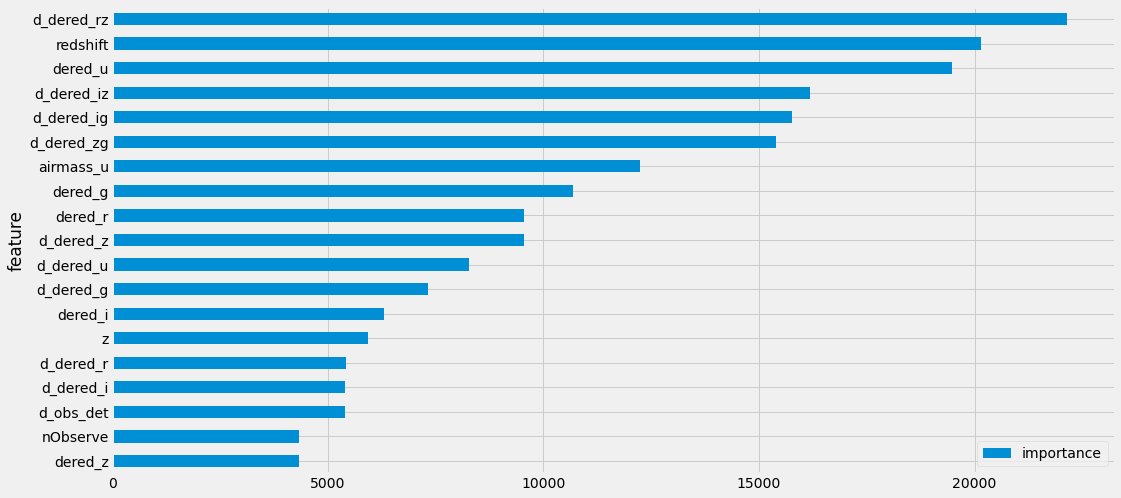

In [48]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [49]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [50]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [52]:
sub[target_col].value_counts()

2    41025
0    29970
1     9005
Name: class, dtype: int64

In [53]:
sub.to_csv(sub_file)